In [1]:
from votekit import load_csv, remove_noncands
from votekit.elections import STV, fractional_transfer, random_transfer
import pandas as pd
import pickle
import jsonlines
import random
import numpy as np
import os
import matplotlib.pyplot as plt

In [196]:
# random transfer EDA
year = 2017
results = []
with jsonlines.open(f'output/school_random_cambridge_{year}.jsonl') as r:
    for line in r:
        results.append(line)

In [197]:
# cleaning and aggregation functions 
WRITEINS = [f'Write-In {i}' for i in range(1,10)]
WRITEINS += [f'Write-In 0{i}' for i in range(1,10)]
WRITEINS += ['WI0']
WRITEINS += [f'WI0{i}' for i in range(1,10)]

def remove_writeins(ranking):
    new_ranking = []
    for cand in ranking:
        if cand not in WRITEINS:
            new_ranking.append(cand)
    
    return tuple(new_ranking) 

def handle_ties(ranking):
    new_ranking = []
    for position in ranking:
        if isinstance(position, list):
            random.shuffle(position)
            new_ranking += position
        else:
            new_ranking.append(position)

    return tuple(new_ranking)

def agg_results(list_of_dicts, key, clean=False):
    unique_results = {}
    for dict in list_of_dicts:
        ranking = tuple(dict[key])
        if any(isinstance(s, list) for s in ranking):
            ranking = handle_ties(ranking)

        if clean:
            ranking = remove_writeins(ranking)

        if ranking not in unique_results:
            unique_results[ranking] = 0
        unique_results[ranking] += 1

    return unique_results

def unique_winners(results):
    winners_dict = {}
    for committe, count, in results.items():
        for cand in committe:
            if cand not in winners_dict:
                winners_dict[cand] = 0
            winners_dict[cand] += count

    return winners_dict

In [198]:
winners = agg_results( results, 'elected',  clean=True)
full_rankings = agg_results(results, 'ranking', clean=True)

In [185]:
winners

{('Nolan, Patricia M.',
  'Bowman, Manikka L.',
  'Dexter, Emily R.',
  'Fantini, Alfred B.',
  'Kelly, Kathleen M.',
  'Kimbrough, Laurance V.'): 9650,
 ('Nolan, Patricia M.',
  'Bowman, Manikka L.',
  'Fantini, Alfred B.',
  'Dexter, Emily R.',
  'Kelly, Kathleen M.',
  'Kimbrough, Laurance V.'): 350}

In [186]:
unique_cands = unique_winners(winners)
cands_df = pd.DataFrame(data={'Candidate': unique_cands.keys(), 'Frequency': unique_cands.values()})
cands_df['Frequency'] = cands_df['Frequency'] / 10000
os.makedirs('results_jan', exist_ok=True)
cands_df.to_csv(f'results_jan/school_committee_freqs_{year}.csv', index=False)

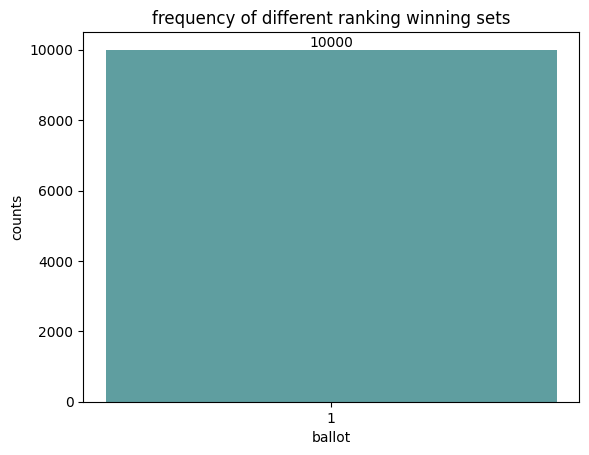

In [83]:
counts = list(winners.values())

fig, ax = plt.subplots()
bar_contain = ax.bar([str(i) for i in range(1, len(counts)+1)], counts, color='cadetblue')
ax.set(ylabel='counts', xlabel='ballot', title='frequency of different ranking winning sets')
ax.bar_label(bar_contain)
os.makedirs('plots_jan', exist_ok=True)
# fig.savefig(f'plots_jan/winning_sets_diff_rankings_{year}.png', dpi=600)

In [64]:
# # kendall tau helper
# def kendall_tau(values1, values2):
#     """Compute the Kendall tau distance."""
#     n = len(values1)
#     assert len(values2) == n, "Both lists have to be of equal length"
#     i, j = np.meshgrid(np.arange(n), np.arange(n))
#     a = np.argsort(values1)
#     b = np.argsort(values2)
#     ndisordered = np.logical_or(np.logical_and(a[i] < a[j], b[i] > b[j]), np.logical_and(a[i] > a[j], b[i] < b[j])).sum()
#     return ndisordered 

In [199]:
def kendall_tau(blist):
    swapcount = 0 
    for j in range(len(blist)):
        for i in range(1, len(blist)-j):
            if blist[i-1] > blist[i]:
                swapcount += 1
                blist[i-1], blist[i] = blist[i], blist[i-1]
    
    return swapcount

In [200]:
# get fractional transfer ranking
cambridge = load_csv(f'data/cambridge_school_{year}.csv')
to_remove = ['skipped', '0)']
cambridge = remove_noncands(cambridge, to_remove)

fract_election = STV(cambridge, transfer=fractional_transfer, seats=6, ballot_ties=False)
fract_results = fract_election.run_election().to_dict()

fract_rank = remove_writeins(cand.strip() for cand in fract_results['ranking'])
fract_committe = remove_writeins(cand.strip() for cand in fract_results['elected'])

In [201]:
des_df = pd.DataFrame(data={'Candidate' : fract_rank, 'Fractional STV Rank': list(range(1, len(fract_rank)+1))})
des_df.to_csv(f'results_jan/school_fract_stv_rank_{year}.csv', index = False)

In [190]:
print('Number of ballots:', cambridge.num_ballots())

Number of ballots: 20686


In [202]:
# fractional vs. random comparison viz
diff_committee = {}
diff_committee['Fractional'] = 0
diff_committee['Random'] = 0 
for committee, weight in winners.items():
    for cand in committee:
        if cand not in fract_committe:
            diff_committee['Random'] += weight
        else:
            diff_committee['Fractional'] += weight

diff_committee

{'Fractional': 60000, 'Random': 0}

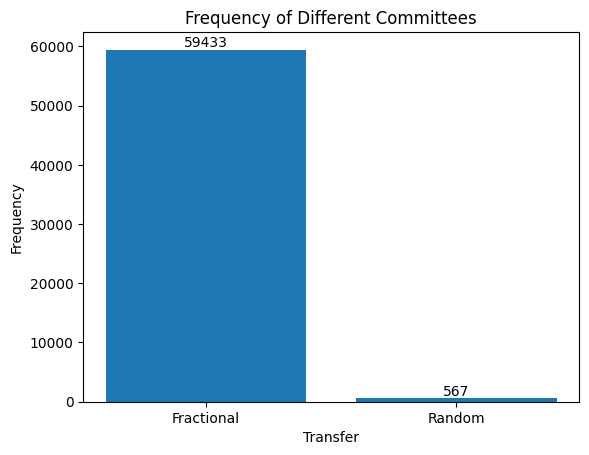

In [176]:
fig, ax = plt.subplots()
bar_contain = ax.bar(diff_committee.keys(), diff_committee.values())
ax.set(ylabel='Frequency', xlabel='Transfer', title='Frequency of Different Committees')
ax.bar_label(bar_contain)
fig.savefig(f'plots_jan/school_fract_random_{year}.png', dpi=600)

In [203]:
# full ranking
kt_values = []
cand_ints = {cand : num + 1 for num, cand in enumerate(fract_rank)}
for ranking in full_rankings.keys():
    num_ranking = [cand_ints[cand] for cand in ranking]
    kt = kendall_tau(num_ranking)
    kt_values.append(kt)
    
rankings_df_wballots = pd.DataFrame(data={'kendall tau': kt_values, 'counts' : list(full_rankings.values()),
                                        'ballots': list(full_rankings.keys()) })
rankings_df_wballots = rankings_df_wballots.sort_values(by=['kendall tau', 'counts'], ascending=[True, False])  
# rankings_df_wballots.to_csv('output/kendall_tau_w_rankings.csv')                          

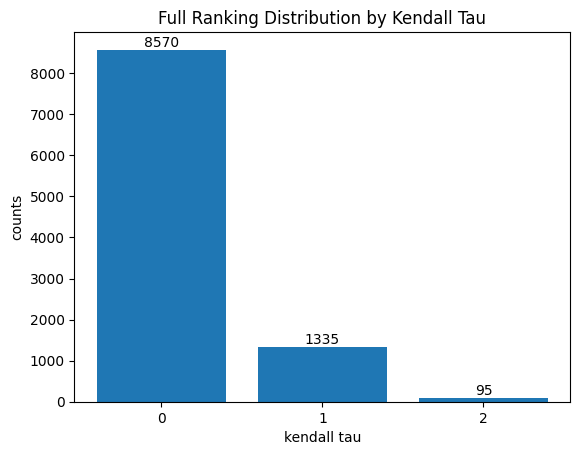

In [204]:
rankings_df = pd.DataFrame(data={'kendall tau': kt_values, 'counts' : list(full_rankings.values())})
rankings_df = rankings_df.groupby('kendall tau').sum().reset_index()
rankings_df = rankings_df.sort_values(by='kendall tau', ascending=True)
rankings_df['kendall tau'] = rankings_df['kendall tau'].astype(str)
fig, ax = plt.subplots()
bar_contain = ax.bar(rankings_df['kendall tau'], rankings_df['counts'])
ax.set(ylabel='counts', xlabel='kendall tau', title='Full Ranking Distribution by Kendall Tau')
ax.bar_label(bar_contain)
fig.savefig(f'plots_jan/school_kendall_tau_full_{year}.png', dpi=600)

In [205]:
# elected committee
kt_values = []
cand_ints = {cand : num + 1 for num, cand in enumerate(fract_committe)}
for ranking in winners.keys():
    num_ranking = [cand_ints[cand] for cand in ranking]
    kt = kendall_tau(num_ranking)
    kt_values.append(kt)
    
winners_df_wballots = pd.DataFrame(data={'kendall tau': kt_values, 'counts' : list(winners.values()),
                                        'ballots': list(winners.keys()) })
winners_df_wballots = winners_df_wballots.sort_values(by=['kendall tau', 'counts'], ascending=[True, False])

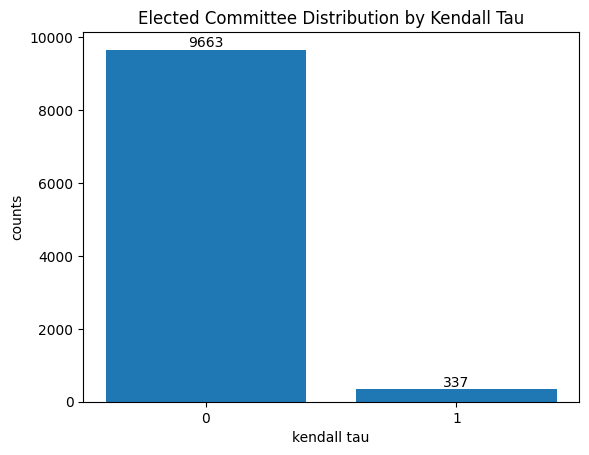

In [206]:
rankings_df = pd.DataFrame(data={'kendall tau': kt_values, 'counts' : list(winners.values())})
rankings_df = rankings_df.groupby('kendall tau').sum().reset_index()
rankings_df = rankings_df.sort_values(by='kendall tau', ascending=True)
rankings_df['kendall tau'] = rankings_df['kendall tau'].astype(str)

fig, ax = plt.subplots()
bar_contain = ax.bar(rankings_df['kendall tau'], rankings_df['counts'])
ax.set(ylabel='counts', xlabel='kendall tau', title='Elected Committee Distribution by Kendall Tau')
ax.bar_label(bar_contain)
fig.savefig(f'plots_jan/school_kendall_tau_committee_{year}.png', dpi=600)

In [189]:
# more pre-simulation data cleaning 
cambridge_profiles = load_csv('data/cambridge_2009_clean.csv')

cambridge_profiles = remove_noncands(cambridge_profiles, ['skipped'])
ballots = cambridge_profiles.get_ballots()

In [4]:
for year in [2013]:
    cambridge_df = pd.read_csv(f'data/cambridge/Cambridge City Council CVR {year}.xlsx - Orderings.csv')
    cambridge_df = cambridge_df[~(cambridge_df.isin(['overvote'])).any(axis=1)]
    cambridge_df = cambridge_df.fillna('skipped')
    cambridge_df.drop('ID', axis=1).to_csv(f'data/cambridge_{year}.csv', index=False)

In [67]:
year = 2015
cambridge_df = pd.read_csv(f'data/cambridge/Cambridge City Council CVR {year}.xlsx - Orderings.csv')
cambridge_df = cambridge_df[~(cambridge_df.isin(['overvote'])).any(axis=1)]
cambridge_df = cambridge_df.fillna('skipped')
cambridge_df.iloc[:, 2:].to_csv(f'data/cambridge_{year}.csv', index=False)

In [71]:
years = [2003, 2005, 2007, 2009, 2011, 2015, 2017]
ballot_lst = []
for year in years:
    profile = load_csv(f'data/cambridge_{year}.csv')
    ballot_lst.append(remove_noncands(profile, ['skipped']).get_ballots())

In [105]:
# data cleaning: 2005
cambridge_df = pd.read_csv('data/cambridge/Cambridge City Council CVR 2005.xlsx - Orderings.csv')
for col in cambridge_df.columns:
    cambridge_df= cambridge_df[~cambridge_df[col].astype(str).str.contains('=')]
cambridge_df = cambridge_df.fillna('skipped')
cambridge_df.drop('ID', axis=1).to_csv(f'data/cambridge_{2005}.csv', index=False)

for col in cambridge_df.columns:
    cambridge_df= cambridge_df[~cambridge_df[col].astype(str).str.contains('=')]

7

In [ ]:
# data cleaning: 2009
cambridge_df = pd.read_csv('data/Cambridge city council 2009.csv')
cambridge_df = cambridge_df[~(cambridge_df.isin(['overvote'])).any(axis=1)]
cambridge_df.to_csv('data/cambridge_2009_clean.csv', index=False)

[(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]


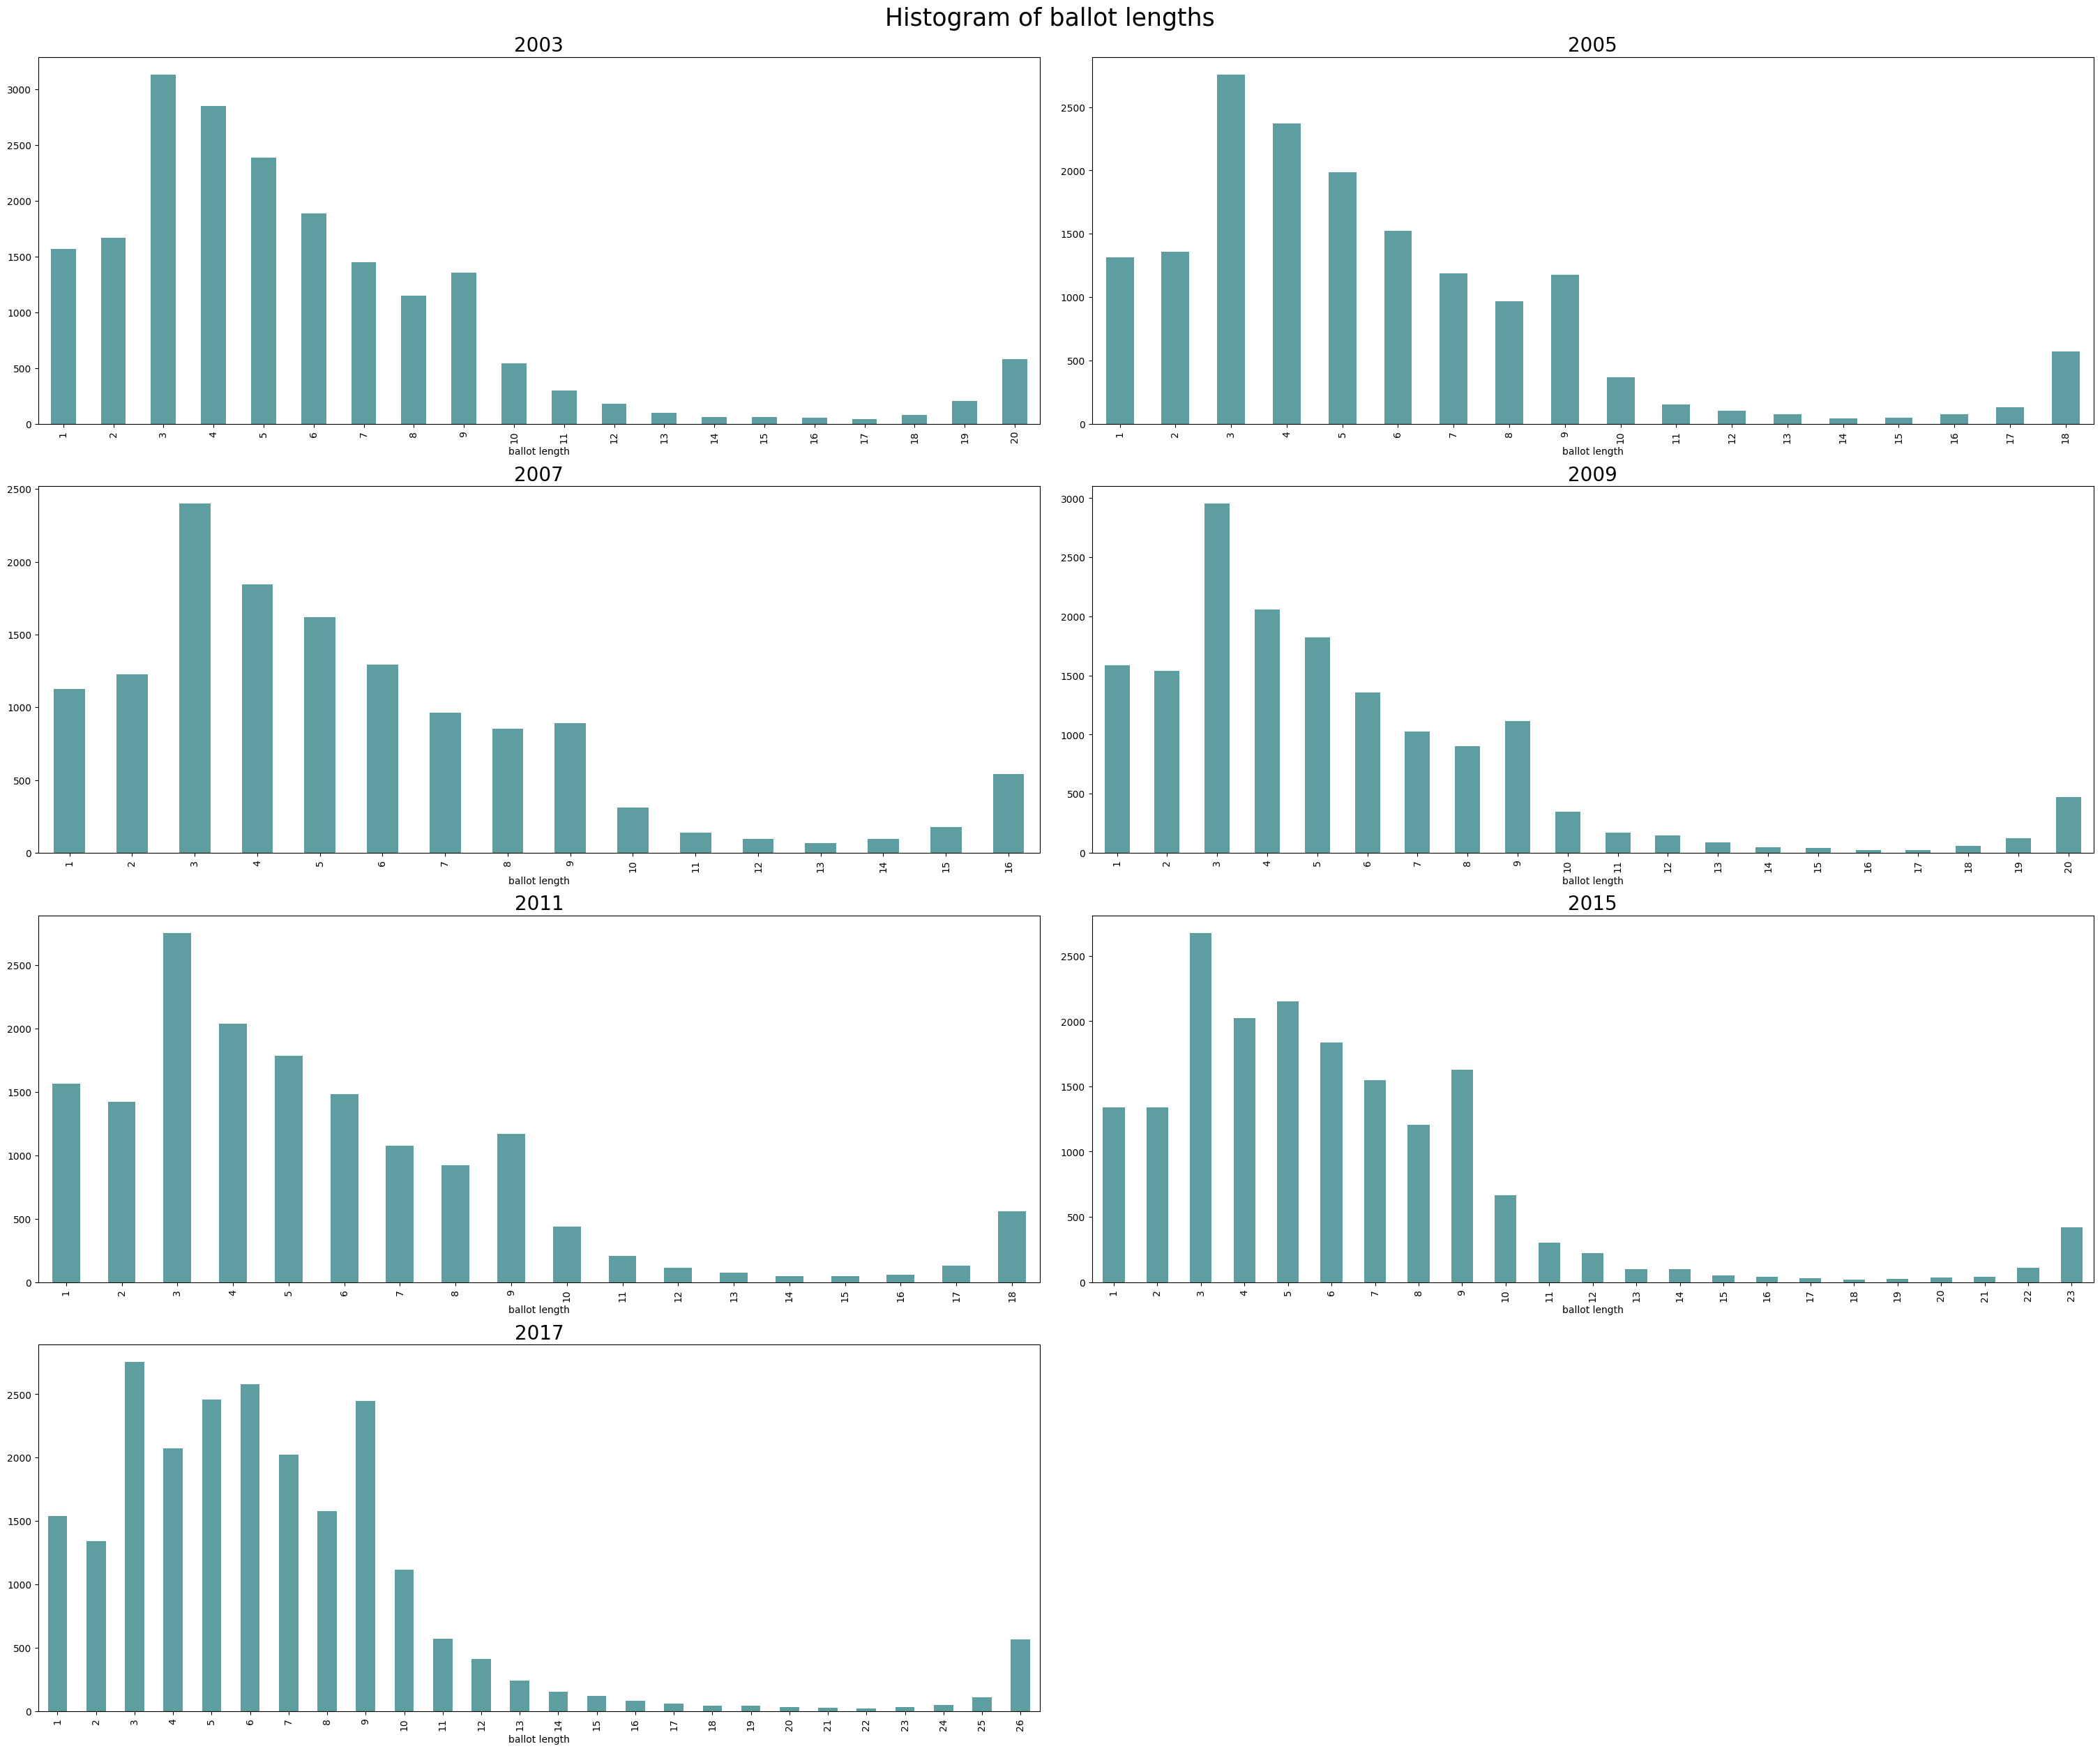

In [115]:
years = [2003, 2005, 2007, 2009, 2011, 2015, 2017]
rows = 4
cols = 2
coords =[]
for i in range(rows):
        for j in range(cols):
            coords.append((i,j))

print(coords)
fig, axes = plt.subplots(rows, cols, figsize=(30, 25), constrained_layout=True)
for (x, y), year, ballots_per_year in zip(coords, years, ballot_lst):

    ballot_lengths = {}
    for ballot in ballots_per_year:
        length = len(ballot.ranking)
        if length not in ballot_lengths:
            ballot_lengths[length] = 0
        ballot_lengths[length] += int(ballot.weight)


    bl_df = pd.DataFrame(data={'ballot length': list(ballot_lengths.keys()),
                                'frequency' : list(ballot_lengths.values())})

    bl_df['ballot length'] = bl_df['ballot length'].astype(int)
    bl_df.sort_values(by='ballot length', ascending=True).reset_index().plot(kind='bar', x='ballot length', y='frequency', ax=axes[x,y], color='cadetblue', legend=False)
    axes[x,y].set_title(year, loc='center', fontsize=20)
fig.delaxes(axes[3,1])
fig.suptitle('Histogram of ballot lengths', fontsize=25)
fig.savefig('plots/ballot_histogram_2003_2017.png', dpi=600)

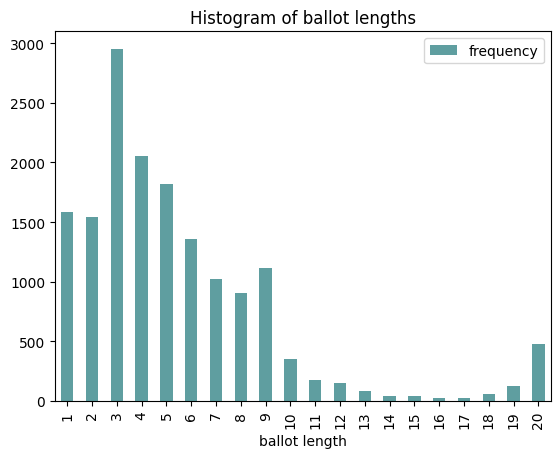

In [190]:
# this should go in VoteKit 
ballot_lengths = {}
for ballot in ballots:
    length = len(ballot.ranking)
    if length not in ballot_lengths:
        ballot_lengths[length] = 0
    ballot_lengths[length] += int(ballot.weight)

ballot_lengths

bl_df = pd.DataFrame(data={'ballot length': list(ballot_lengths.keys()),
                            'frequency' : list(ballot_lengths.values())})

bl_df.sort_values(by='ballot length', ascending=True).plot(kind='bar', x='ballot length', y='frequency', color='cadetblue',
                                                            title='Histogram of ballot lengths').get_figure().savefig('plots/ballot_histogram.png', dpi=600)

In [207]:
# school cvr cleaning
for year in range(2005, 2017+1, 2):
    if year == 2009:
        continue
    school = pd.read_csv(f'data/cambridge_school/Cambridge_{year}_SchoolCommittee.csv')
    school = school[~(school.isin(['overvote'])).any(axis=1)]
    school.to_csv(f'data/cambridge_school_{year}.csv', index=False)

In [208]:
# 2009 school cvr cleaning

cambridge_df = pd.read_csv('data/cambridge_school/Cambridge_2009_SchoolCommittee.csv')
for col in cambridge_df.columns:
    cambridge_df= cambridge_df[~cambridge_df[col].astype(str).str.contains('=')]
cambridge_df = cambridge_df.fillna('skipped')
cambridge_df.to_csv('data/cambridge_school_2009.csv', index=False)